# Metrics Calculations

Stylometrics requires the calculation of a variety of metrics that go beyond assessing metrics about text length. Here is a quick overview:

1. Readability Metrics- assesses a text's readability level.

2. Vocabulary Richness- looks at the variety of word types in a text.

3. Function Word Analysis- count the occurrence of function words.

4. Part of Speech Analysis- analyze the distribution of different word classes.

5. Named Entity Recognition Analysis- analyze the distribution of different named entity types and their most common values.


In [ ]:
# Installations
!pip install textstat
!pip install lexicalrichness
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lexicalrichness: filename=lexicalrichness-0.5.1-py3-none-any.whl size=15414 sha256=29beee5498ecb7a5cab1dd6756c53532fedc4be52420ed6d7626cd6796c3e3e5
  Stored in directory: /root/.cache/pip/wheels/cd/ba/80/d4dabc1bf242a672ffc00226a2303a7471bb841c0872b2c212
Successfully built lexicalrichness


In [ ]:
# spaCy model
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Imports
import os
import sys
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm.notebook import tqdm_notebook
from collections import Counter
import textstat
from lexicalrichness import LexicalRichness
import statistics as st
import scipy.stats as ss

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Custom modules
sys.path.append('/content/drive/MyDrive/Python/MSCAPP/utils/')
%load_ext autoreload
%autoreload 2
from sample_extractor import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Import data
data = pd.read_pickle("/content/drive/MyDrive/Python/MSCAPP/data/merged_data02Feb2024.pkl")

In [ ]:
# Reset the index
data.reset_index(drop=True, inplace=True)

# Check
data.head(2)

,original_id,text_docs,text_word_counts,text_sentence_counts,text_pos_tags,text_lemmas,text_ner_tags,original_text,title_docs,title_word_counts,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,type
0,21221,"(Real, journalism, ended, a, long, time, ago, ...",256,8,"[SPACE, ADJ, CCONJ, ADJ, NOUN, AUX, AUX, ADV, ...","[ , central, and, local, government, will, be,...","[(Central, ORG), (China, GPE), (China Daily, O...","Real journalism ended a long time ago, but thi...","(86, YR, OLD, BARBARA, WALTERS, Tells, 40, Yr,...",12,...,0.038610,0.000000,0.000000,0.019305,0.007722,0.038610,0.003861,0.007722,0.030888,fake
1,18041,"(A, clueless, CNN, reporter, trying, to, inter...",1242,44,"[PUNCT, PROPN, PUNCT, PUNCT, ADP, PROPN, NUM, ...","[(, Reuters, ), -, in, September, 2014, ,, Gil...","[(Reuters, ORG), (September 2014, DATE), (Gilb...",A clueless CNN reporter trying to interview a ...,"(Woman, Just, Rescued, from, #, Harvey, Flood,...",14,...,0.013605,0.006803,0.006803,0.006803,0.020408,0.027211,0.006803,0.006803,0.006803,fake


## Calculate Readability Metrics

Readability metrics indicate the readability level of a text.
- We will use the Automated Readability Index.

$ARI = 4.71(\frac{characters}{words}) + 0.5(\frac{words}{sentences} - 21.43)$

In [ ]:
# Calculate ARI
data['ARI'] = data['original_text'].apply(lambda x: textstat.automated_readability_index(x))

## Vocabulary Richness

Looks at the variety of word types in a text. There are many different metrics we could use here, and I will present the ones I most commonly use:

1. Type-Token Ratio, TTR
2. Measure of Textual Lexical Diversity, MTLD
3. Hapaxes

In [ ]:
# TTR
def ttrCalc(text):
  '''
  Uses lexicalrichness package to calculate the Type-Token Ratio.
  Returns the TTR value.
  '''
  assert len(text) > 1, "Text is too small. Check text lengths and try again."
  # New text object
  lex = LexicalRichness(text)
  # Return TTR
  return lex.ttr


In [ ]:
# Calculate TTR
data['TTR'] = data['original_text'].apply(lambda x: ttrCalc(x))

### Measure of Textual Lexical Diversity (MTLD)

In [ ]:
# MTLD
def mtldCalc(text):
  '''
  Uses lexicalrichness package to calculate the Measure of Textual Lexical Diversity.
  Returns the MTLD value.
  '''
  # New text object
  lex = LexicalRichness(text)
  # Return MTLD
  return lex.mtld(0.72)

In [ ]:
# Calculate MTLD
data['MTLD'] = data['original_text'].apply(lambda x: mtldCalc(x))

### Hapaxes

In [ ]:
# Hapaxes
def hapaxCalc(text):
  '''
  Determine hapaxes per text.
  Use word tokenization to create a Counter object.
  Filter counter object to a list of words that appear only once.
  Return a list of hapaxes.
  '''
  # Get the word tokens counter
  word_token_counter = Counter([t for t in text.split() if t.isalnum()])
  # Filter the Counter to values of only 1
  hapaxes = [key for key, value in word_token_counter.items() if value == 1]
  # Return the list
  return hapaxes


In [ ]:
# Find hapaxes
data['hapaxes'] = data['original_text'].apply(lambda x: hapaxCalc(x))

# Get the count of hapaxes
data['hapaxes_count'] = data['hapaxes'].apply(lambda x: len(x))

In [ ]:
# Find any matches between hapaxes and NER tags
def hapaxNER(hapax_list, ner_list):
  '''
  Compares a hapax list to a NER list.
  Returns a list of the corresponding NER for each hapax.
  '''
  # Create an empty list to hold the hapax-to-NER matches
  hapax_ner_matches = []
  # Filter the NER list to unique values to avoid over-counting
  ner_list_set = set(ner_list)
  # Loop the hapax list
  for hapax in hapax_list:
    # Loop the NER list
    for ner in ner_list_set:
      # If the hapax matches the NER
      if hapax in ner:
        # Append to hapax_ner_matches the hapax and the corresponding NER tag
        hapax_ner_matches.append((hapax, ner[1]))
  # Return list even if null
  return hapax_ner_matches


In [ ]:
# Get matches of hapax-to-NER
data['hapax_ner_matches'] = data.apply(lambda x: hapaxNER(x['hapaxes'], x['text_ner_tags']), axis=1)

# Get hapax-NER match counts
data['hapax_ner_match_counts'] = data.apply(lambda x: len(x['hapax_ner_matches']), axis=1)

In [ ]:
# Find matches between hapaxes and POS tags
def hapaxPOS(hapax_list, doc):
  '''
  Compares a hapax list to a POS list.
  Returns a list of the corresponding POS for each hapax.
  '''
  # Create an empty list to hold matches
  hapax_pos_matches = []
  # POS list
  pos_list = posTagExtractor(doc)
  # Word tokens
  word_token_list = [token.text for token in doc]
  # Zip POS and token text
  word_pos_list = list(zip(word_token_list, pos_list))
  # Loop the hapax list
  for hapax in hapax_list:
    # Loop the POS list
    for word, pos in word_pos_list:
      # If the hapax matches the word
      if hapax == word:
        # Append to hapax_pos_matches the hapax and the corresponding POS tag
        hapax_pos_matches.append((hapax, pos))
  # Return list even if null
  return hapax_pos_matches

In [ ]:
# Get matches of hapax-to-POS
data['hapax_pos_matches'] = data.apply(lambda x: hapaxPOS(x['hapaxes'], x['text_docs']), axis=1)

# Get hapax-POS match counts
data['hapax_pos_match_counts'] = data.apply(lambda x: len(x['hapax_pos_matches']), axis=1)

## Function Word Analysis + Part of Speech Analysis

Function words serve grammatical functions within a text as opposed to conveying specific lexical meanings. It makes sense to pair this with part of speech analysis as we will be using the POS tags generated by spaCy.

In [ ]:
# Make a list
all_pos_tags = []

# Iterate
for i in tqdm_notebook(range(data.shape[0])):
  # Iterate each tag per text
  for pos in data.text_pos_tags[i]:
    # Append
    all_pos_tags.append(pos)

# Create a set
all_pos_tags_set = set(all_pos_tags)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
# Define POS tags for function words - https://github.com/explosion/spaCy/blob/master/spacy/glossary.py
function_pos_tags = ['ADP', 'AUX', 'DET', 'INTJ', 'SCONJ']

In [ ]:
# Content POS tags
content_pos_tags = ['ADJ', 'ADV','NOUN', 'NUM', 'PROPN', 'VERB']


In [ ]:
# Create new columns in data per unique pos tag
for tag in all_pos_tags_set:
  data[tag] = 0

In [ ]:
# Add counts of tags per text
for i in tqdm_notebook(range(data.shape[0])):
  # Counter per text
  text_pos_counter = Counter(data.text_pos_tags[i])
  # Get the intersection in all_pos_tags_set and counter keys
  intersecting_keys = all_pos_tags_set.intersection(text_pos_counter.keys())
  # Iterate the intersecting keys
  for key in intersecting_keys:
    # Add the count to the corresponding column
    data.loc[i, key] = text_pos_counter[key]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
# Replace NaN
for col in data.columns:
  if col in all_pos_tags_set:
    data[col].fillna(0, inplace=True)

In [ ]:
# Calculate FCR
data['function_word_ratio'] = data[function_pos_tags].sum(axis=1) / data[content_pos_tags].sum(axis=1)

## Named Entity Recognition Analysis

This looks at the variety of tags in texts, and may extend to the values most commonly associated with those tags.

In [ ]:
# Make a list
all_ner_tags = []

# Iterate
for i in tqdm_notebook(range(data.shape[0])):
  # Iterate each tag per text
  for ner in data.text_ner_tags[i]:
    # Append
    all_ner_tags.append(ner[1])

# Create a set
all_ner_tags_set = set(all_ner_tags)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
# Create new columns in data per unique ner tag
for tag in all_ner_tags_set:
  data[tag] = 0

In [ ]:
# Add counts of tags per text
for i in tqdm_notebook(range(data.shape[0])):
  # NER tags per text
  this_text_ner_tags = [record[1] for record in data.text_ner_tags[i]]
  # Counter per text
  text_ner_counter = Counter(this_text_ner_tags)
  # Get the intersection in all_pos_tags_set and counter keys
  ner_intersecting_keys = all_ner_tags_set.intersection(text_ner_counter.keys())
  # Iterate the intersecting keys
  for key in ner_intersecting_keys:
    # Add the count to the corresponding column
    data.loc[i, key] = text_ner_counter[key]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
# Calculate median word length per text
data['median_word_length'] = data.apply(lambda x: st.median([len(word) for word in x['text_docs']]), axis=1)

In [ ]:
# Calculate median sentence length per text
data['median_sentence_length'] = data.apply(lambda x: st.median([len(sent) for sent in x['text_docs'].sents]), axis=1)

## Exploratory Data Analysis

### Text Analytics

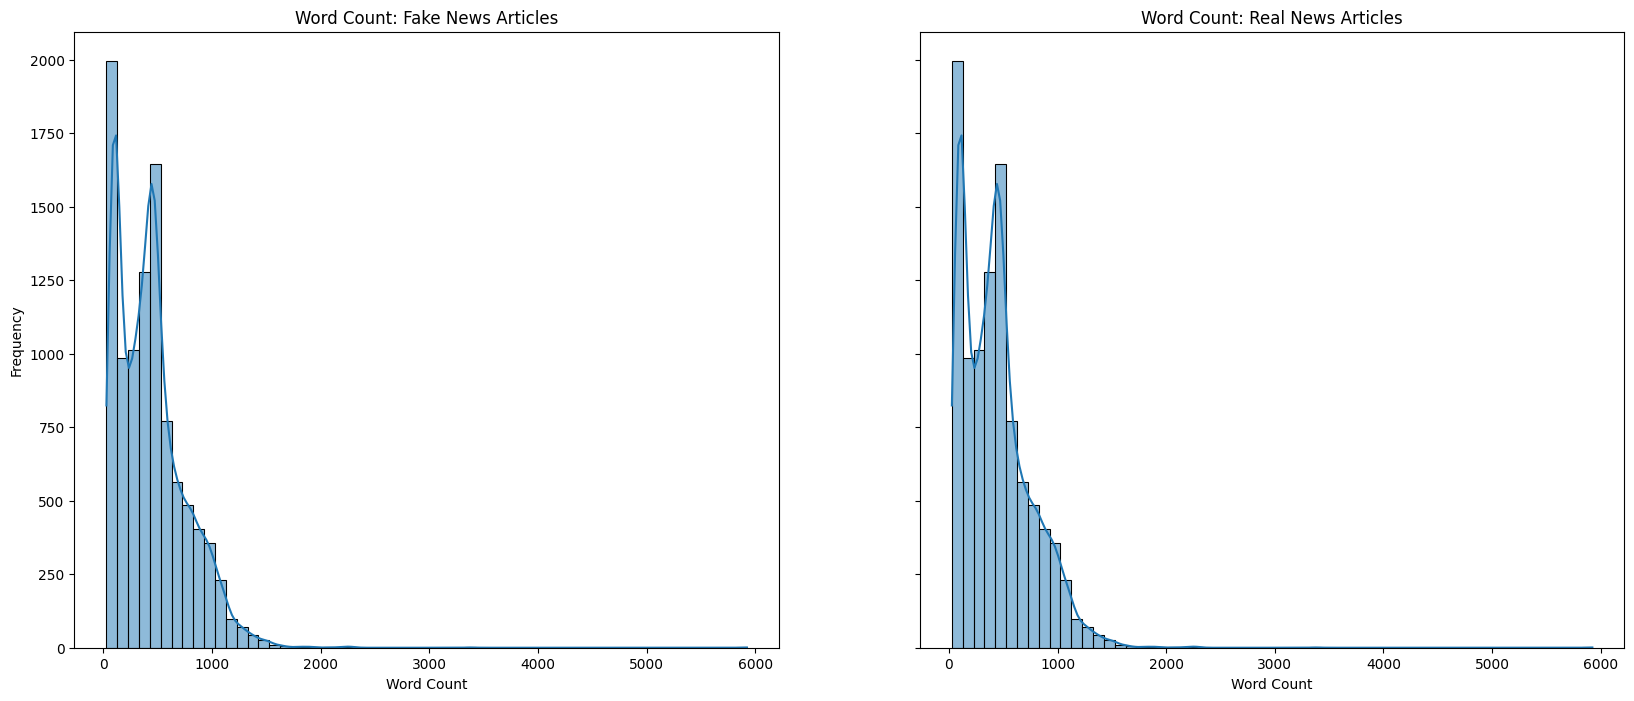

In [ ]:
# Subplots
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(20, 8))

# Axes
wc_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='text_word_counts', binwidth=100, kde=True, alpha=0.5, ax=ax0)
wc_histplot_fake.set_title('Word Count: Fake News Articles')
wc_histplot_fake.set_xlabel('Word Count')
wc_histplot_fake.set_ylabel('Frequency')

wc_histplot_true = sns.histplot(data=data[data.type=='real'], x='text_word_counts', binwidth=100, kde=True, alpha=0.5, ax=ax1)
wc_histplot_true.set_title('Word Count: Real News Articles')
wc_histplot_true.set_xlabel('Word Count')
wc_histplot_true.set_ylabel('Frequency')

# Show
plt.show()

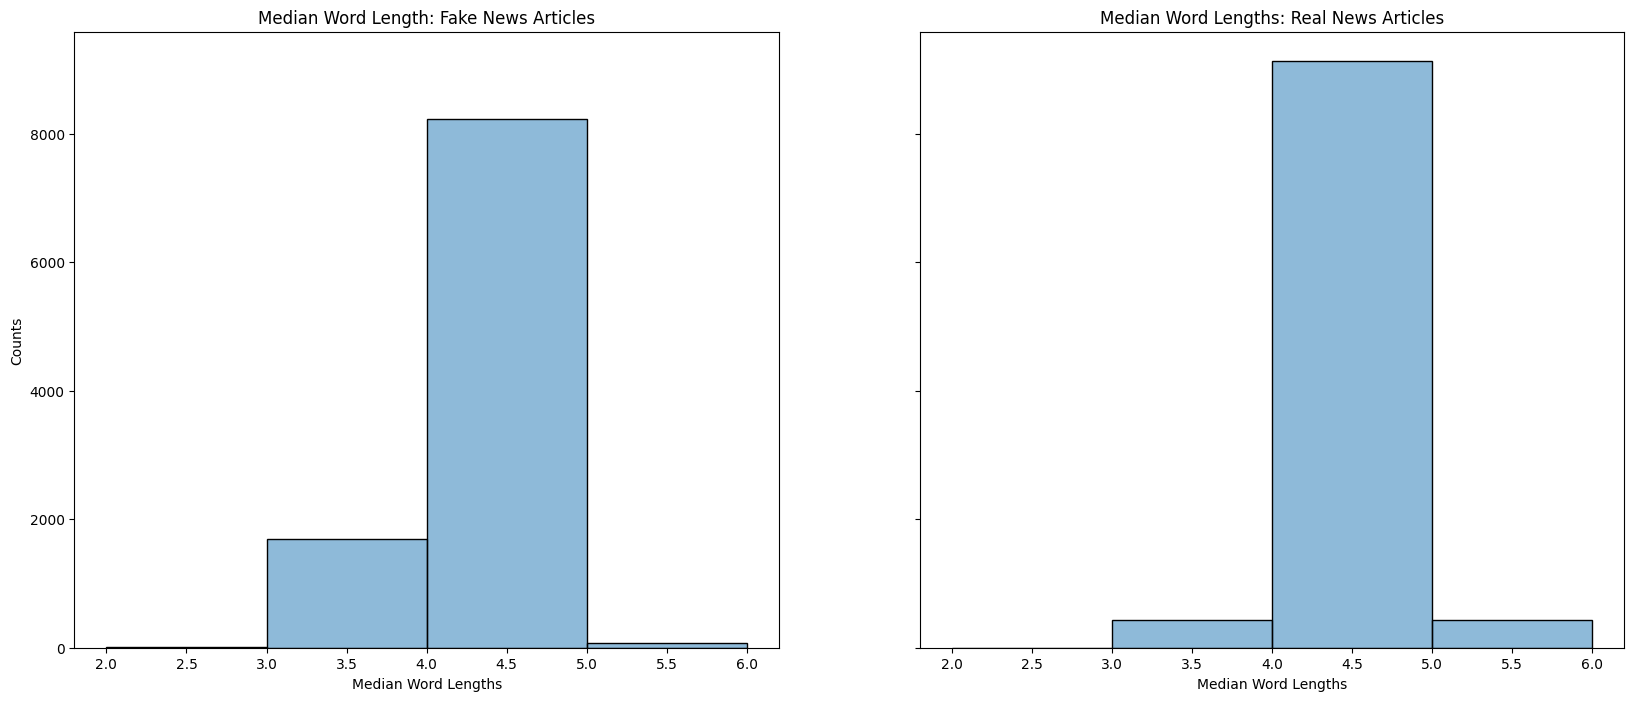

In [ ]:
# Subplots
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(20, 8))

# Axes
med_wl_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='median_word_length', binwidth=1, alpha=0.5, ax=ax0)
med_wl_histplot_fake.set_title('Median Word Length: Fake News Articles')
med_wl_histplot_fake.set_xlabel('Median Word Lengths')
med_wl_histplot_fake.set_ylabel('Counts')

med_wl_histplot_true = sns.histplot(data=data[data.type=='real'], x='median_word_length', binwidth=1, alpha=0.5, ax=ax1)
med_wl_histplot_true.set_title('Median Word Lengths: Real News Articles')
med_wl_histplot_true.set_xlabel('Median Word Lengths')
med_wl_histplot_true.set_ylabel('Counts')

# Show
plt.show()

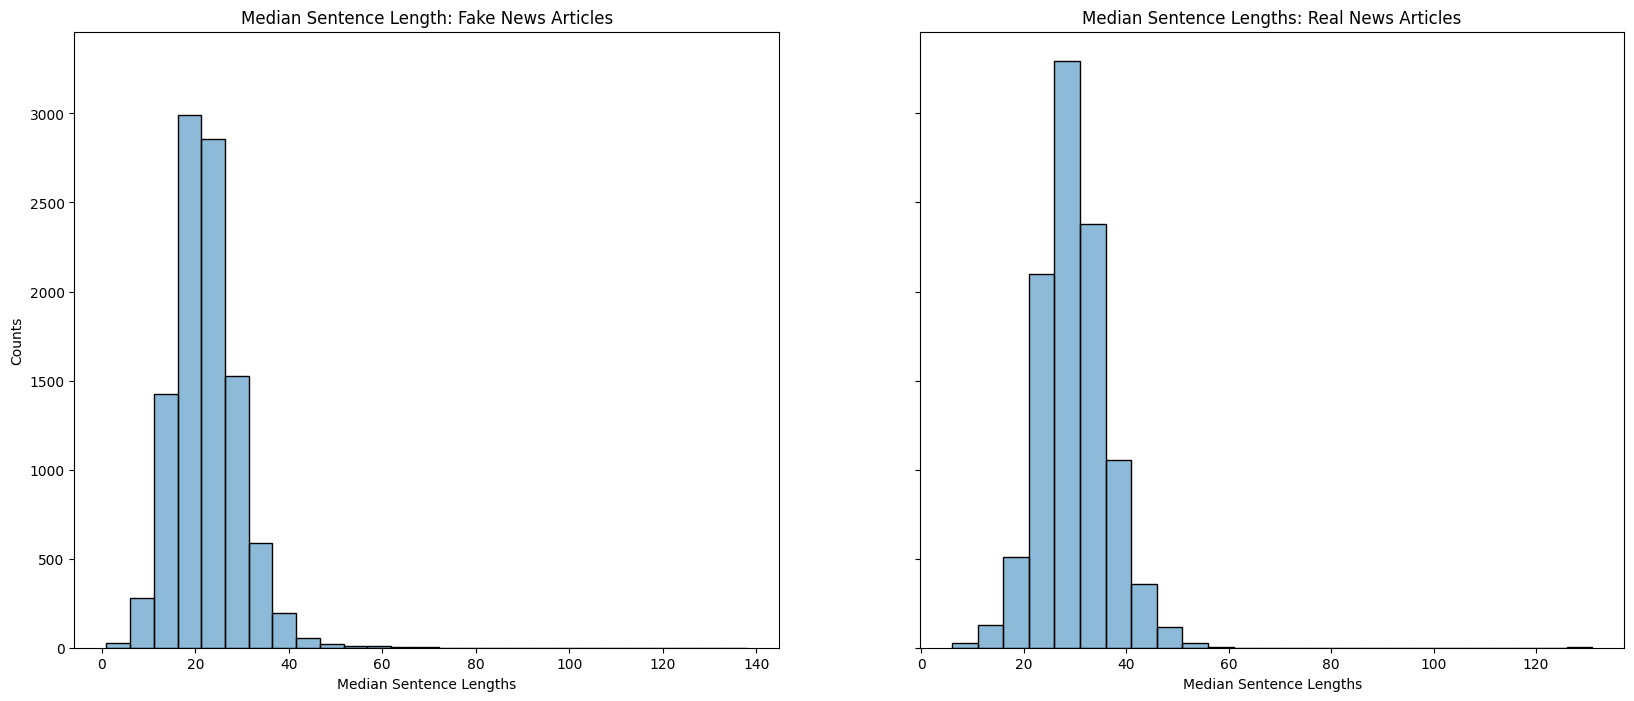

In [ ]:
# Subplots
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(20, 8))

# Axes
med_sl_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='median_sentence_length', binwidth=5, alpha=0.5, ax=ax0)
med_sl_histplot_fake.set_title('Median Sentence Length: Fake News Articles')
med_sl_histplot_fake.set_xlabel('Median Sentence Lengths')
med_sl_histplot_fake.set_ylabel('Counts')

med_sl_histplot_true = sns.histplot(data=data[data.type=='real'], x='median_sentence_length', binwidth=5, alpha=0.5, ax=ax1)
med_sl_histplot_true.set_title('Median Sentence Lengths: Real News Articles')
med_sl_histplot_true.set_xlabel('Median Sentence Lengths')
med_sl_histplot_true.set_ylabel('Counts')

# Show
plt.show()

In [ ]:
# Emotion columns
emo_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

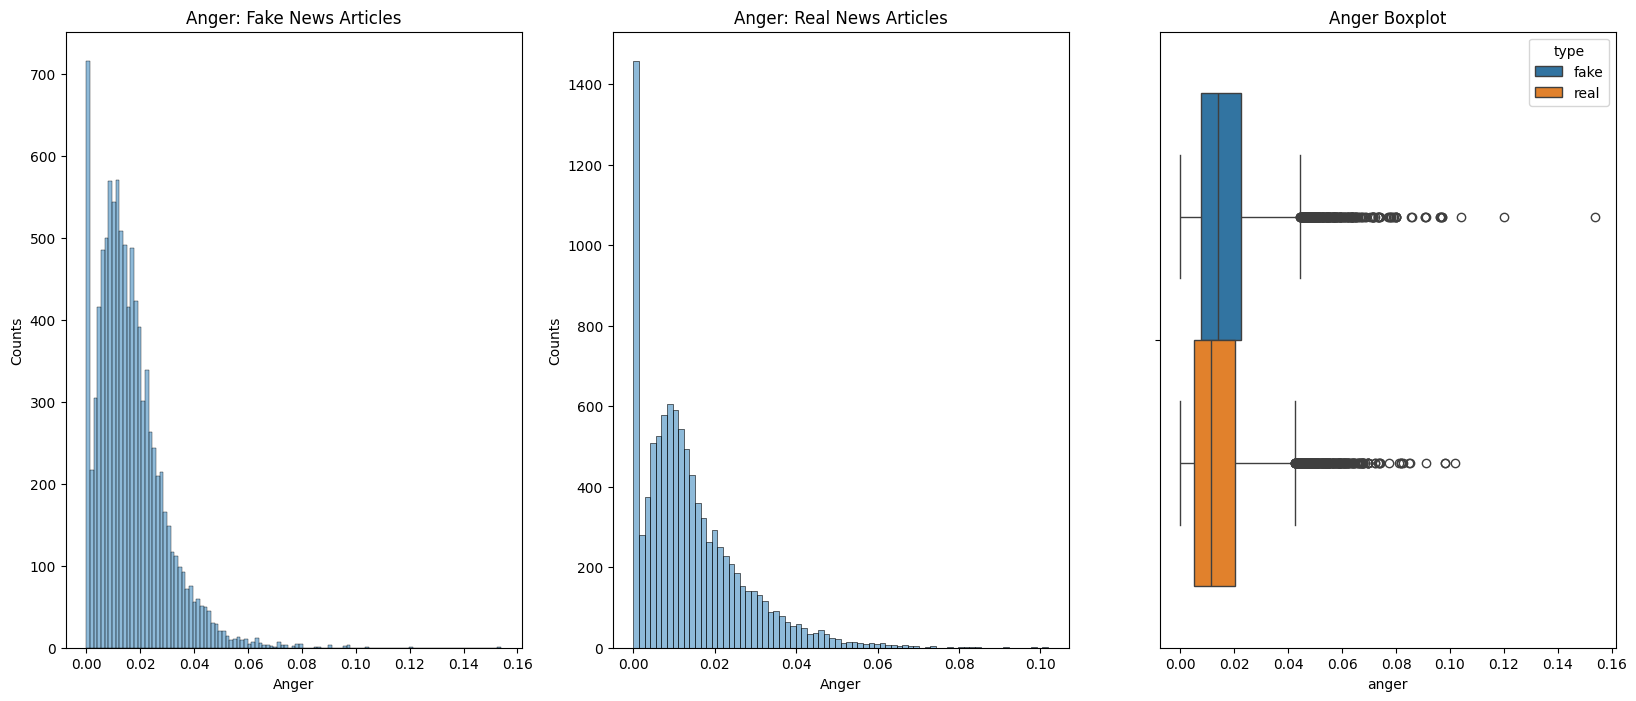

In [ ]:
# Subplot- Anger
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))

# Axes
anger_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='anger', alpha=0.5, ax=ax0)
anger_histplot_fake.set_title('Anger: Fake News Articles')
anger_histplot_fake.set_xlabel('Anger')
anger_histplot_fake.set_ylabel('Counts')

anger_histplot_true = sns.histplot(data=data[data.type=='real'], x='anger', alpha=0.5, ax=ax1)
anger_histplot_true.set_title('Anger: Real News Articles')
anger_histplot_true.set_xlabel('Anger')
anger_histplot_true.set_ylabel('Counts')

anger_boxplot = sns.boxplot(data=data, x='anger', hue='type', ax=ax2)
anger_boxplot.set_title('Anger Boxplot')

# Show
plt.show()

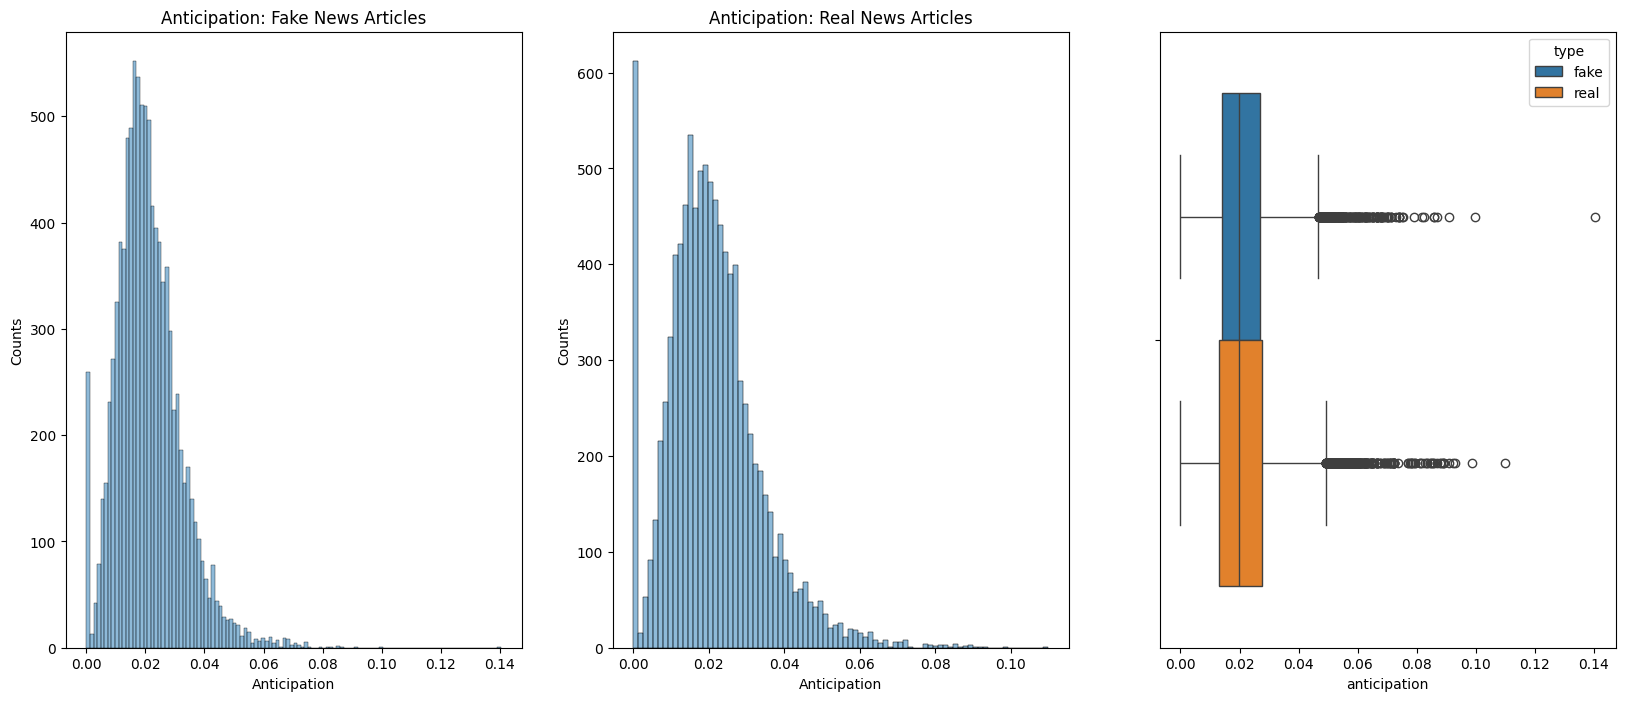

In [ ]:
# Subplot- Anticipation
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))

# Axes
anticipation_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='anticipation', alpha=0.5, ax=ax0)
anticipation_histplot_fake.set_title('Anticipation: Fake News Articles')
anticipation_histplot_fake.set_xlabel('Anticipation')
anticipation_histplot_fake.set_ylabel('Counts')

anticipation_histplot_true = sns.histplot(data=data[data.type=='real'], x='anticipation', alpha=0.5, ax=ax1)
anticipation_histplot_true.set_title('Anticipation: Real News Articles')
anticipation_histplot_true.set_xlabel('Anticipation')
anticipation_histplot_true.set_ylabel('Counts')

anticipation_boxplot = sns.boxplot(data=data, x='anticipation', hue='type', ax=ax2)

# Show
plt.show()

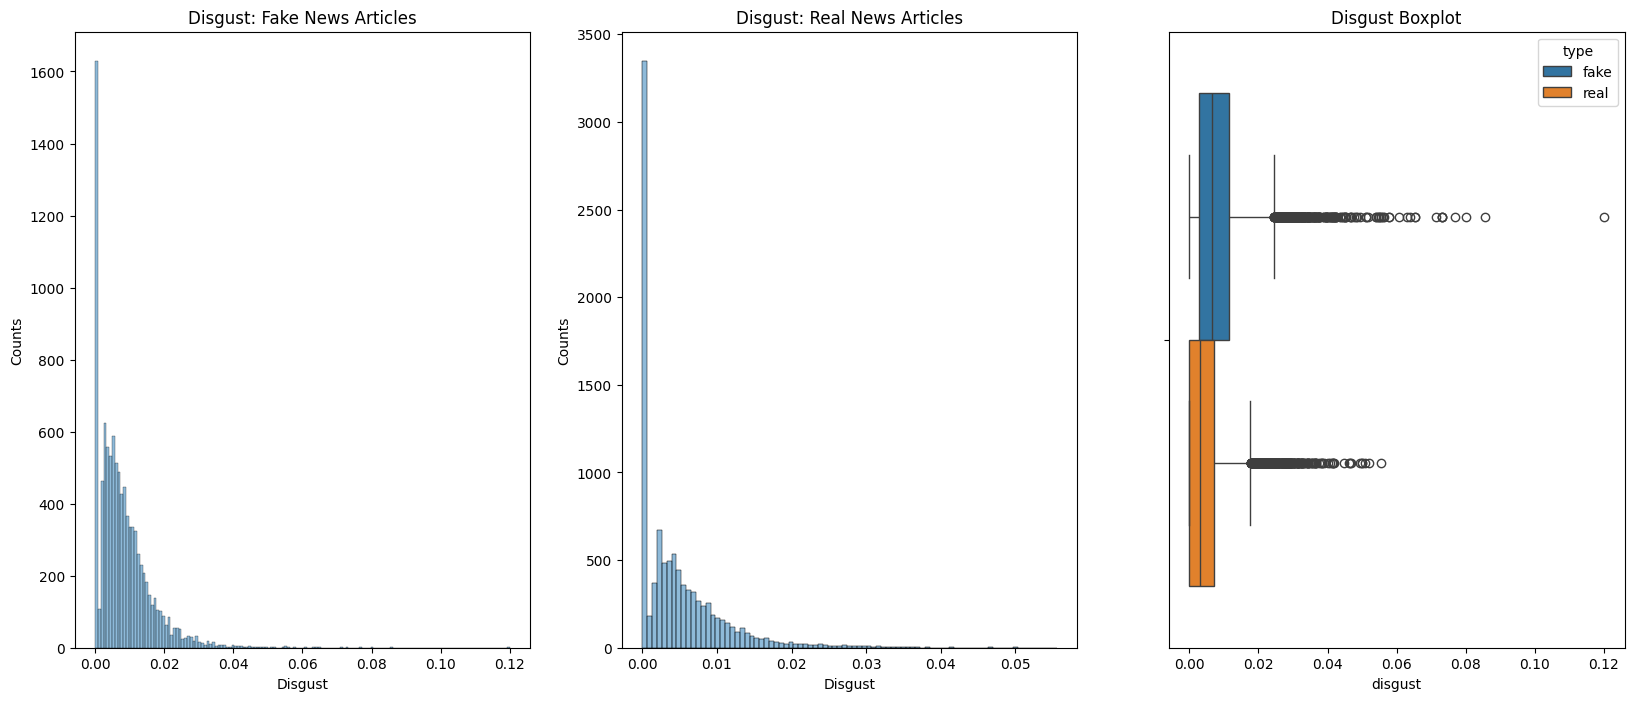

In [ ]:
# Subplots - Disgust
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))

# Axes
disgust_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='disgust', alpha=0.5, ax=ax0)
disgust_histplot_fake.set_title('Disgust: Fake News Articles')
disgust_histplot_fake.set_xlabel('Disgust')
disgust_histplot_fake.set_ylabel('Counts')

disgust_histplot_true = sns.histplot(data=data[data.type=='real'], x='disgust', alpha=0.5, ax=ax1)
disgust_histplot_true.set_title('Disgust: Real News Articles')
disgust_histplot_true.set_xlabel('Disgust')
disgust_histplot_true.set_ylabel('Counts')

disgust_boxplot = sns.boxplot(data=data, x='disgust', hue='type', ax=ax2)
disgust_boxplot.set_title('Disgust Boxplot')

# Show
plt.show()

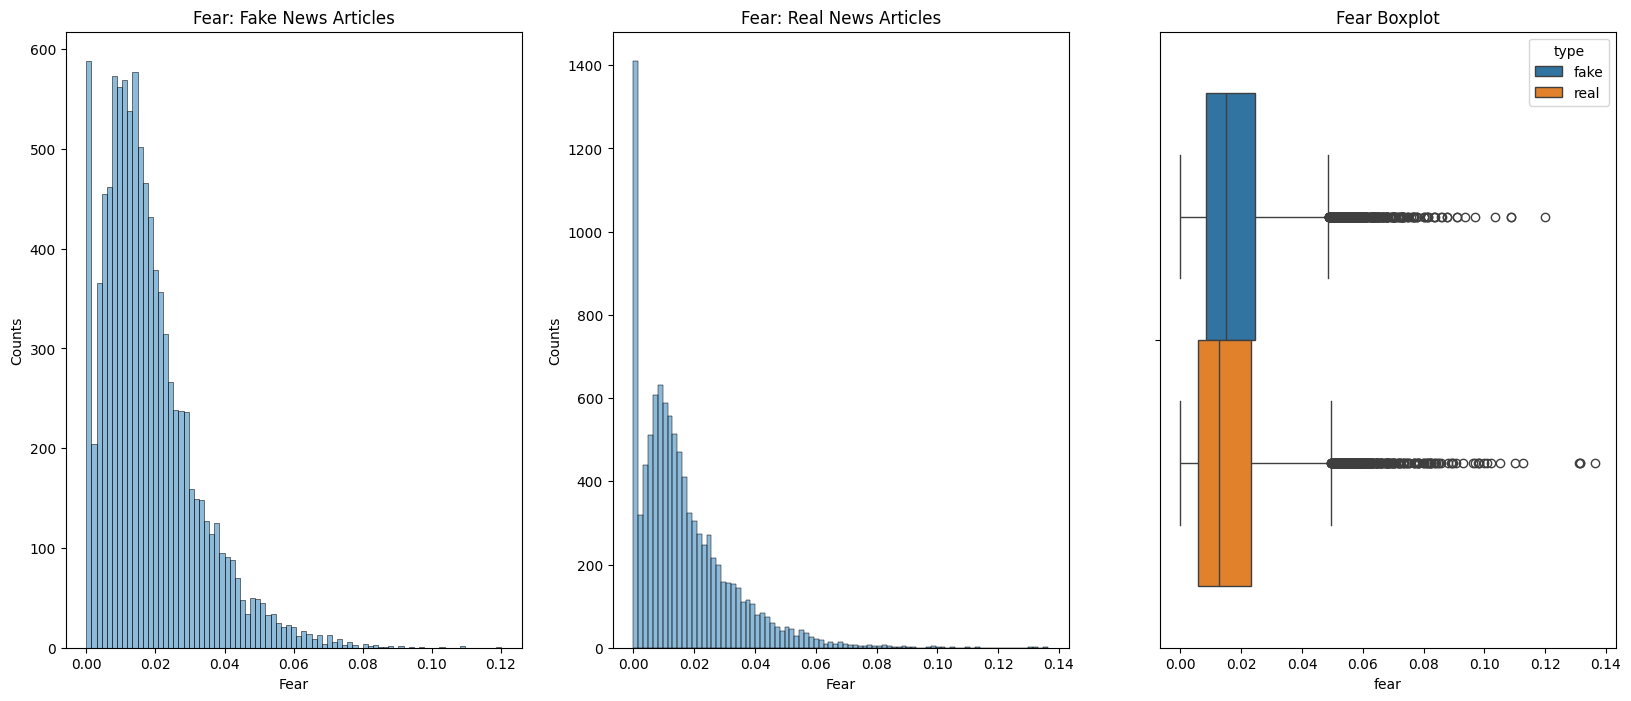

In [ ]:
# Subplots - Fear
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))

# Axes
fear_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='fear', alpha=0.5, ax=ax0)
fear_histplot_fake.set_title('Fear: Fake News Articles')
fear_histplot_fake.set_xlabel('Fear')
fear_histplot_fake.set_ylabel('Counts')

fear_histplot_true = sns.histplot(data=data[data.type=='real'], x='fear', alpha=0.5, ax=ax1)
fear_histplot_true.set_title('Fear: Real News Articles')
fear_histplot_true.set_xlabel('Fear')
fear_histplot_true.set_ylabel('Counts')

fear_boxplot = sns.boxplot(data=data, x='fear', hue='type', ax=ax2)
fear_boxplot.set_title('Fear Boxplot')

# Show
plt.show()

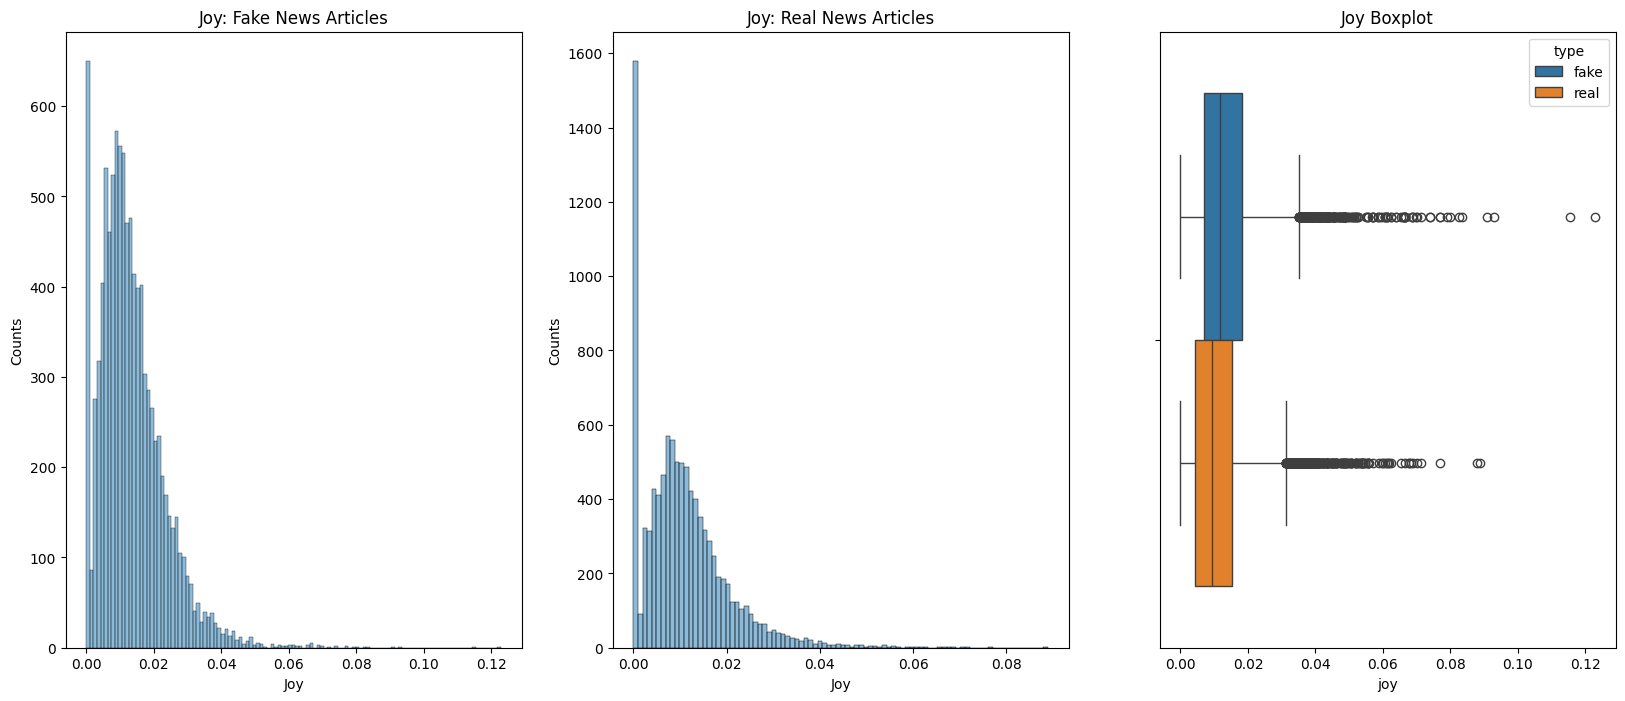

In [ ]:
# Subplots - joy
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))

# Axes
joy_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='joy', alpha=0.5, ax=ax0)
joy_histplot_fake.set_title('Joy: Fake News Articles')
joy_histplot_fake.set_xlabel('Joy')
joy_histplot_fake.set_ylabel('Counts')

joy_histplot_true = sns.histplot(data=data[data.type=='real'], x='joy', alpha=0.5, ax=ax1)
joy_histplot_true.set_title('Joy: Real News Articles')
joy_histplot_true.set_xlabel('Joy')
joy_histplot_true.set_ylabel('Counts')

joy_boxplot = sns.boxplot(data=data, x='joy', hue='type', ax=ax2)
joy_boxplot.set_title('Joy Boxplot')

# Show
plt.show()

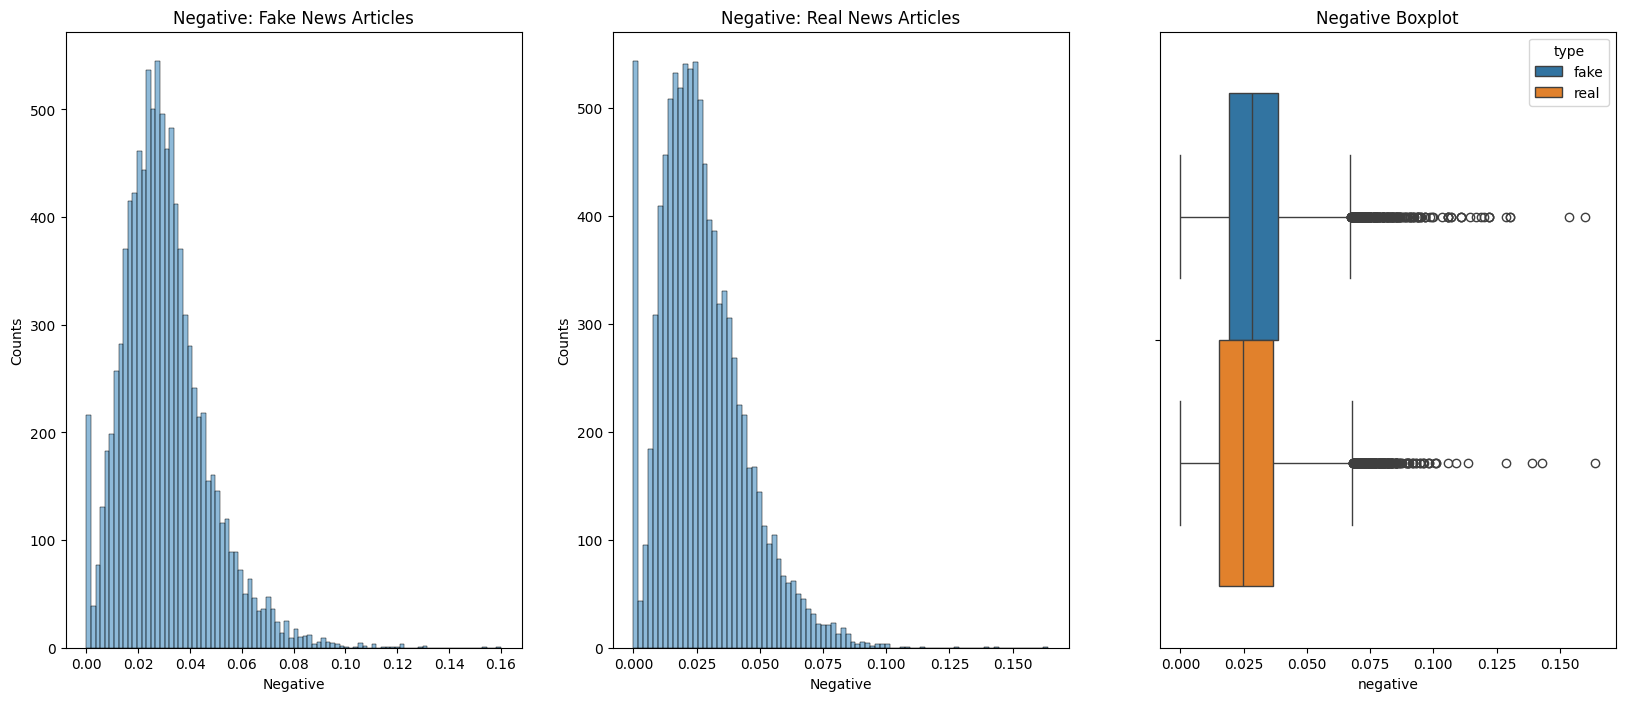

In [ ]:
# Subplots - Negative
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))

# Axes
negative_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='negative', alpha=0.5, ax=ax0)
negative_histplot_fake.set_title('Negative: Fake News Articles')
negative_histplot_fake.set_xlabel('Negative')
negative_histplot_fake.set_ylabel('Counts')

negative_histplot_true = sns.histplot(data=data[data.type=='real'], x='negative', alpha=0.5, ax=ax1)
negative_histplot_true.set_title('Negative: Real News Articles')
negative_histplot_true.set_xlabel('Negative')
negative_histplot_true.set_ylabel('Counts')

negative_boxplot = sns.boxplot(data=data, x='negative', hue='type', ax=ax2)
negative_boxplot.set_title('Negative Boxplot')

# Show
plt.show()

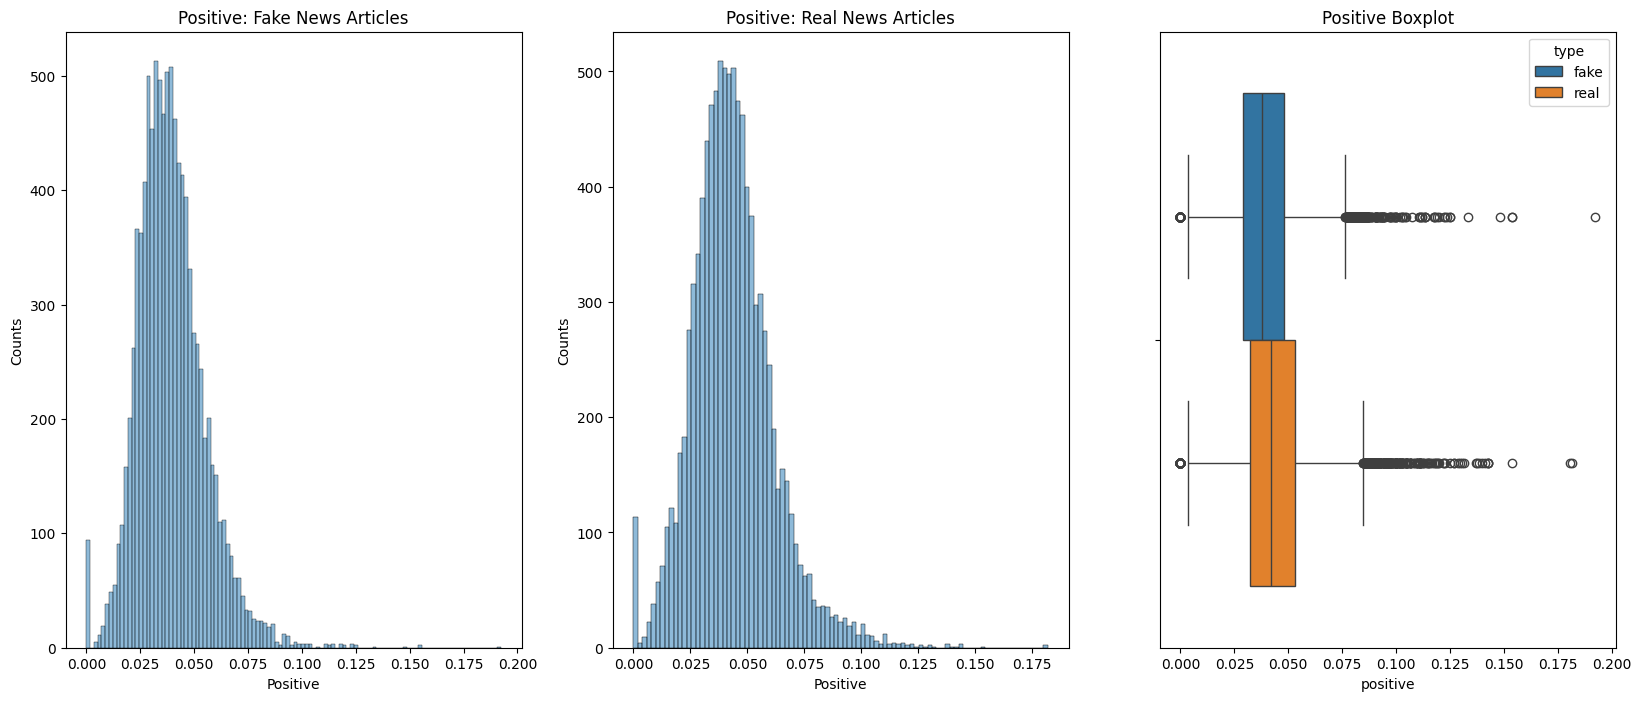

In [ ]:
# Subplots - Positive
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))

# Axes
positive_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='positive', alpha=0.5, ax=ax0)
positive_histplot_fake.set_title('Positive: Fake News Articles')
positive_histplot_fake.set_xlabel('Positive')
positive_histplot_fake.set_ylabel('Counts')

positive_histplot_true = sns.histplot(data=data[data.type=='real'], x='positive', alpha=0.5, ax=ax1)
positive_histplot_true.set_title('Positive: Real News Articles')
positive_histplot_true.set_xlabel('Positive')
positive_histplot_true.set_ylabel('Counts')

positive_boxplot = sns.boxplot(data=data, x='positive', hue='type', ax=ax2)
positive_boxplot.set_title('Positive Boxplot')

# Show
plt.show()

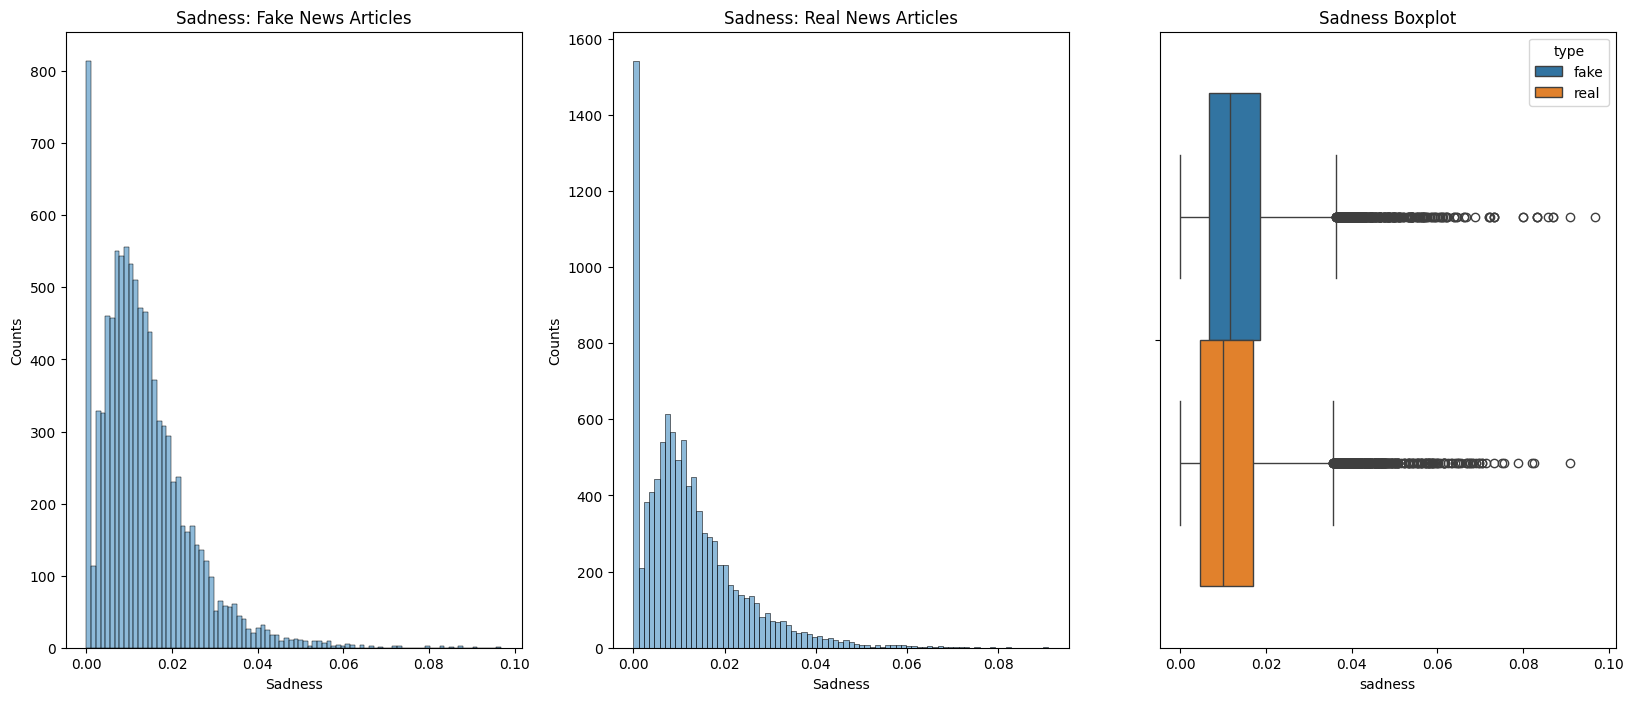

In [ ]:
# Subplots - Sadness
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,8))

# Axes
sadness_histplot_fake = sns.histplot(data=data[data.type == 'fake'], x='sadness', alpha=0.5, ax=ax0)
sadness_histplot_fake.set_title('Sadness: Fake News Articles')
sadness_histplot_fake.set_xlabel('Sadness')
sadness_histplot_fake.set_ylabel('Counts')

sadness_histplot_true = sns.histplot(data=data[data.type=='real'], x='sadness', alpha=0.5, ax=ax1)
sadness_histplot_true.set_title('Sadness: Real News Articles')
sadness_histplot_true.set_xlabel('Sadness')
sadness_histplot_true.set_ylabel('Counts')

sadness_boxplot = sns.boxplot(data=data, x='sadness', hue='type', ax=ax2)
sadness_boxplot.set_title('Sadness Boxplot')

# Show
plt.show()

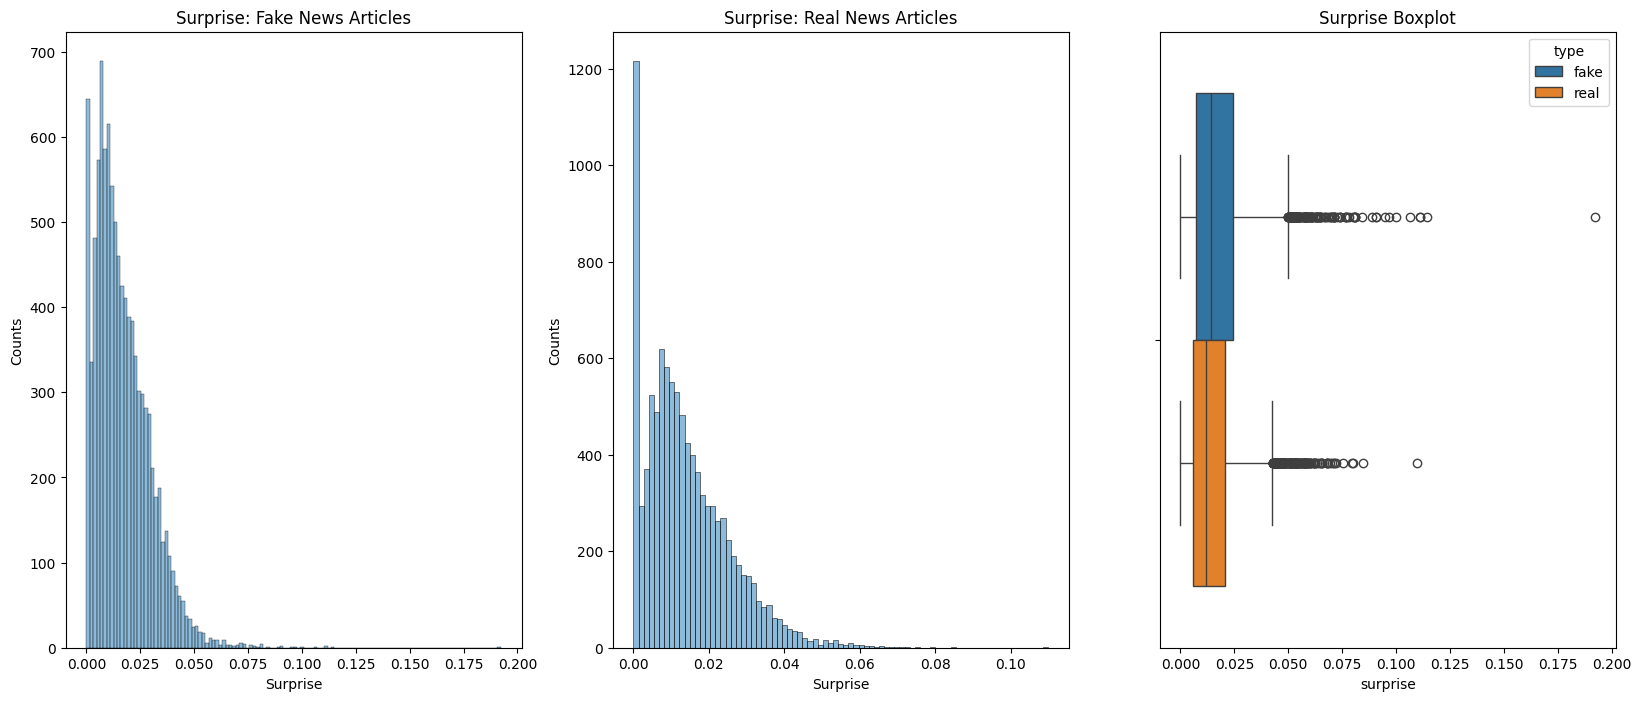

In [ ]:
# Subplots - Surprise
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))

# Axes
surprise_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='surprise', alpha=0.5, ax=ax0)
surprise_histplot_fake.set_title('Surprise: Fake News Articles')
surprise_histplot_fake.set_xlabel('Surprise')
surprise_histplot_fake.set_ylabel('Counts')

surprise_histplot_true = sns.histplot(data=data[data.type=='real'], x='surprise', alpha=0.5, ax=ax1)
surprise_histplot_true.set_title('Surprise: Real News Articles')
surprise_histplot_true.set_xlabel('Surprise')
surprise_histplot_true.set_ylabel('Counts')

surprise_boxplot = sns.boxplot(data=data, x='surprise', hue='type', ax=ax2)
surprise_boxplot.set_title('Surprise Boxplot')

# Show
plt.show()

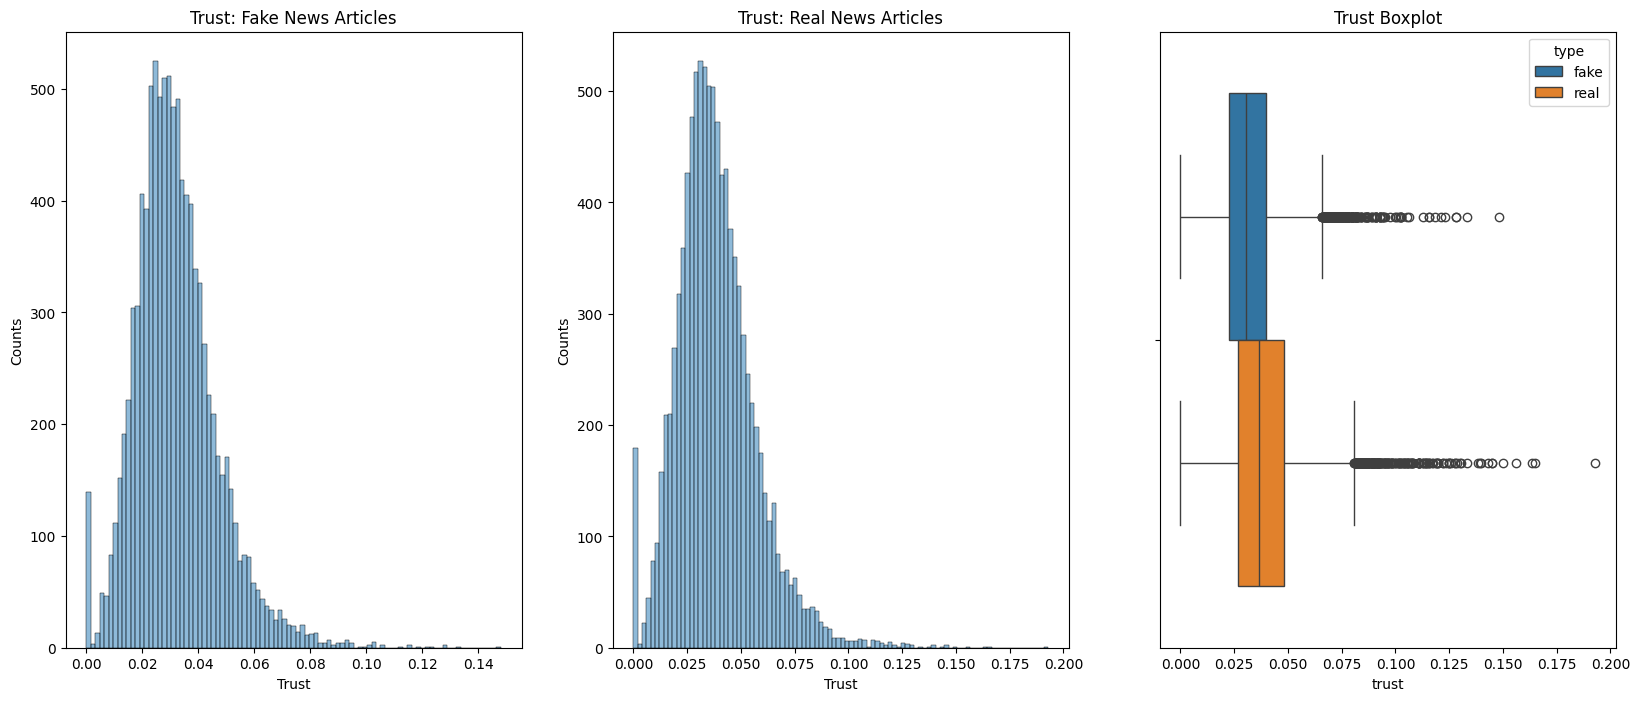

In [ ]:
# Subplots - Trust
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))

# Axes
trust_histplot_fake = sns.histplot(data=data[data.type=='fake'], x='trust', alpha=0.5, ax=ax0)
trust_histplot_fake.set_title('Trust: Fake News Articles')
trust_histplot_fake.set_xlabel('Trust')
trust_histplot_fake.set_ylabel('Counts')

trust_histplot_true = sns.histplot(data=data[data.type=='real'], x='trust', alpha=0.5, ax=ax1)
trust_histplot_true.set_title('Trust: Real News Articles')
trust_histplot_true.set_xlabel('Trust')
trust_histplot_true.set_ylabel('Counts')

trust_boxplot = sns.boxplot(data=data, x='trust', hue='type', ax=ax2)
trust_boxplot.set_title('Trust Boxplot')

# Show
plt.show()

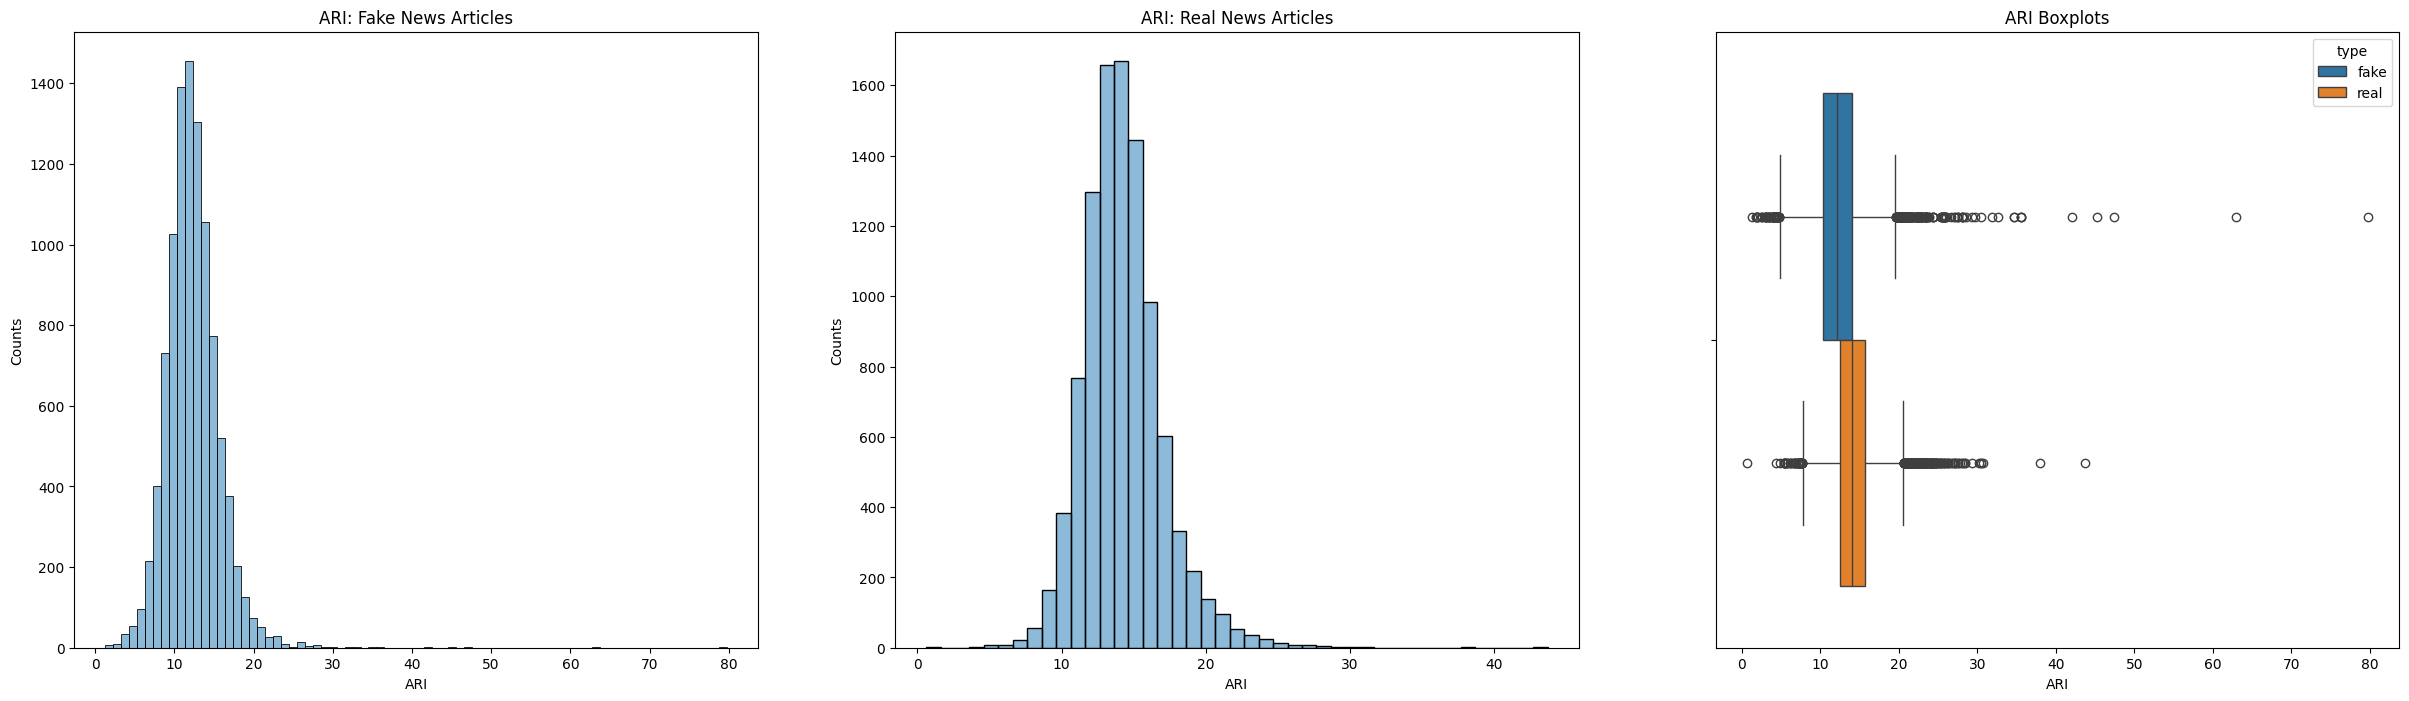

In [ ]:
# ARI scores
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(30,8))

# Axes
ari_fake = sns.histplot(data=data[data.type == 'fake'], x='ARI', binwidth=1, alpha=0.5, ax=ax0)
ari_fake.set_title('ARI: Fake News Articles')
ari_fake.set_xlabel('ARI')
ari_fake.set_ylabel('Counts')

ari_true = sns.histplot(data=data[data.type=='real'], x='ARI', binwidth=1, alpha=0.5, ax=ax1)
ari_true.set_title('ARI: Real News Articles')
ari_true.set_xlabel('ARI')
ari_true.set_ylabel('Counts')

ari_boxplot = sns.boxplot(data=data, x='ARI', hue='type', ax=ax2)
ari_boxplot.set_title('ARI Boxplots')

# Show
plt.show()

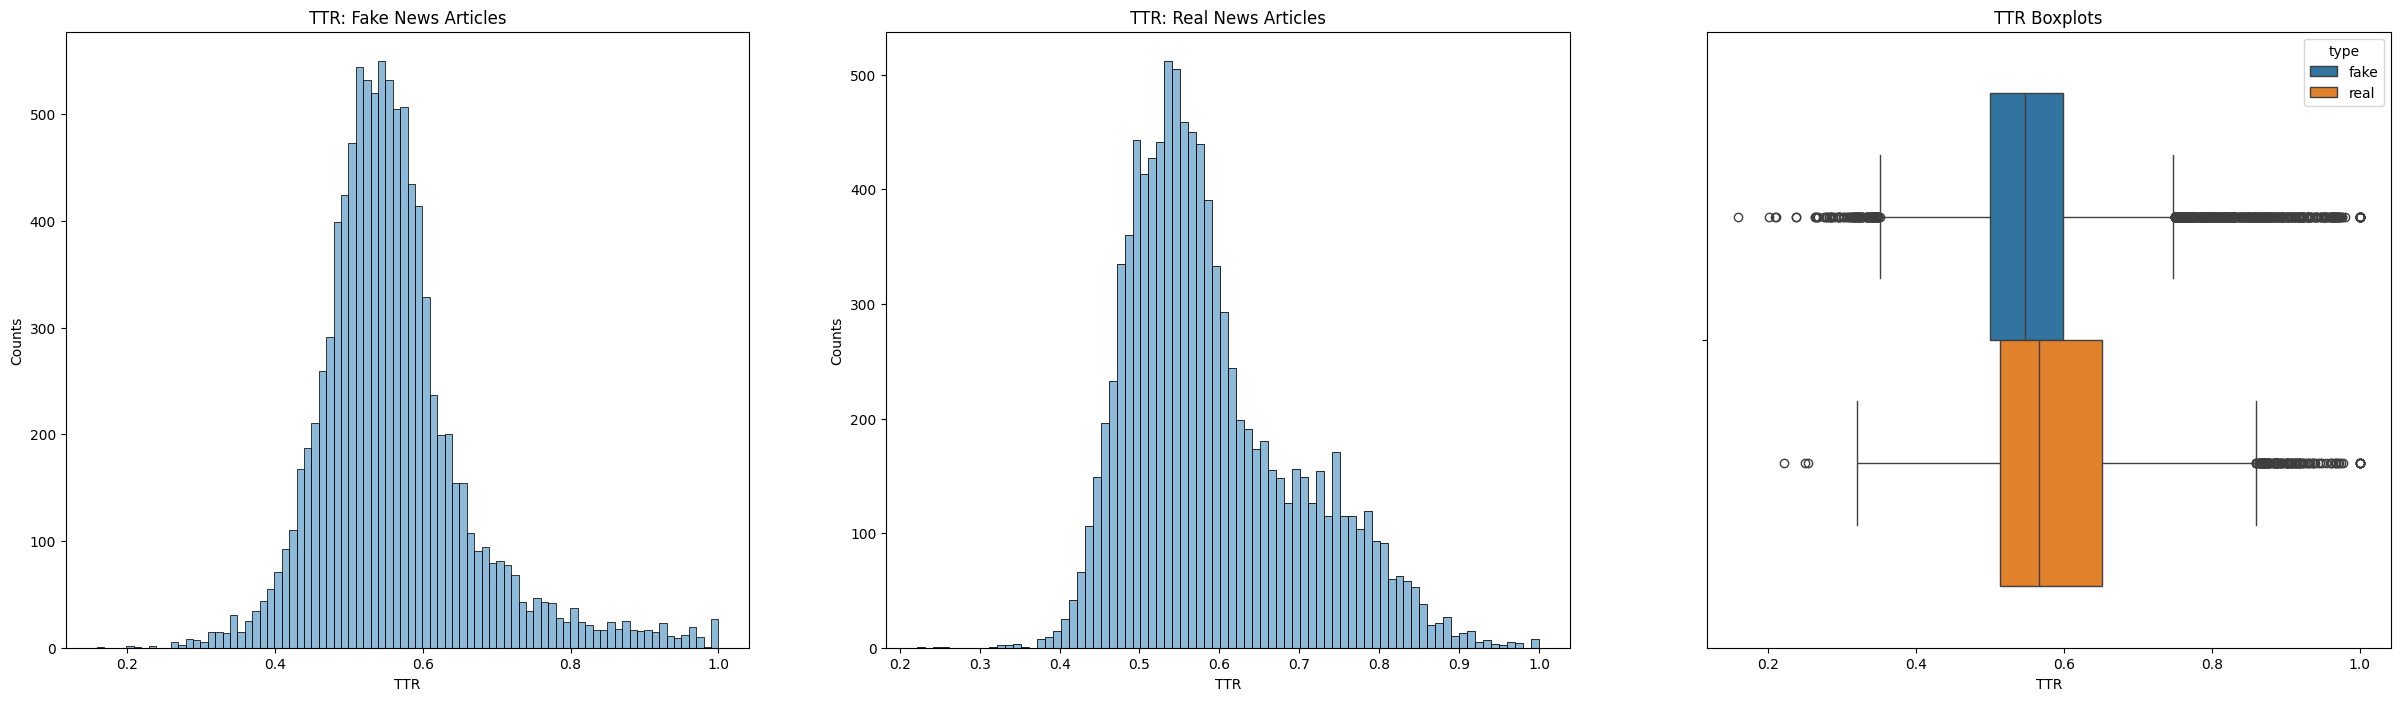

In [ ]:
# TTR
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(30,8))

# Axes
ttr_fake = sns.histplot(data=data[data.type == 'fake'], x='TTR', binwidth=0.01, alpha=0.5, ax=ax0)
ttr_fake.set_title('TTR: Fake News Articles')
ttr_fake.set_xlabel('TTR')
ttr_fake.set_ylabel('Counts')

ttr_true = sns.histplot(data=data[data.type=='real'], x='TTR', binwidth=0.01, alpha=0.5, ax=ax1)
ttr_true.set_title('TTR: Real News Articles')
ttr_true.set_xlabel('TTR')
ttr_true.set_ylabel('Counts')

ttr_boxplot = sns.boxplot(data=data, x='TTR', hue='type', ax=ax2)
ttr_boxplot.set_title('TTR Boxplots')

# Show
plt.show()

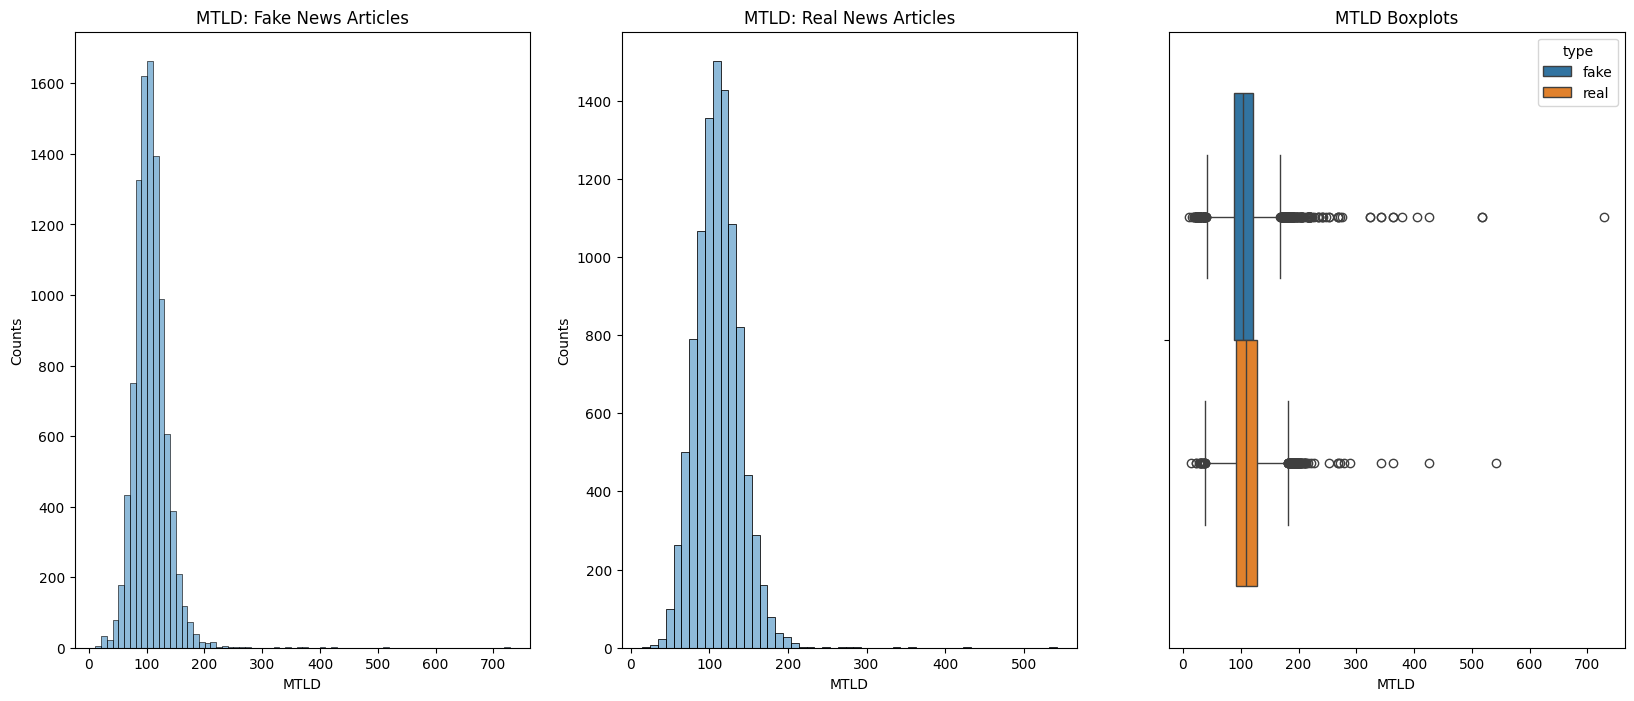

In [ ]:
# MTLD
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,8))

# Axes
mtld_fake = sns.histplot(data=data[data.type == 'fake'], x='MTLD', binwidth=10, alpha=0.5, ax=ax0)
mtld_fake.set_title('MTLD: Fake News Articles')
mtld_fake.set_xlabel('MTLD')
mtld_fake.set_ylabel('Counts')

mtld_true = sns.histplot(data=data[data.type=='real'], x='MTLD', binwidth=10, alpha=0.5, ax=ax1)
mtld_true.set_title('MTLD: Real News Articles')
mtld_true.set_xlabel('MTLD')
mtld_true.set_ylabel('Counts')

mtld_boxplot = sns.boxplot(data=data, x='MTLD', hue='type', ax=ax2)
mtld_boxplot.set_title('MTLD Boxplots')

# Show
plt.show()

In [ ]:
# Drop docs
data = data.drop(columns=['text_docs', 'title_docs'])

# Pickle the dataset for safety
data.to_pickle('/content/drive/MyDrive/Python/MSCAPP/data/processed_text_02Feb2024.pkl')